# **Step 1: Import Libraries**

In [1]:
pip install fastai 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Standard Libraries
import os
import zipfile
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from glob import glob

# Import Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import TensorFlow
import tensorflow as tf

**Set Seed for Reproducibility**

In [ ]:
SEED = 42

def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set Seed for Reproducibility
seed_everything()

# **Step 2: Load Data**

In [ ]:
# Define Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Function to Extract ZIP File
def extract_data(zip_path, extracted_path):
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract Data # TODO
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 3: Data Preprocessing**

In [ ]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Load labels and preprocess
def load_labels(csv_path, image_path):
    labels_df = pd.read_csv(csv_path)

    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)


# **Step 4: Exploratory Data Analysis (EDA)**

**Number of Unique Patients**

In [ ]:
unique_patients = labels_df['Patient ID'].nunique()
print(f"Number of Unique Patients: {unique_patients}")

Number of Unique Patients: 30805


**Label Distribution**

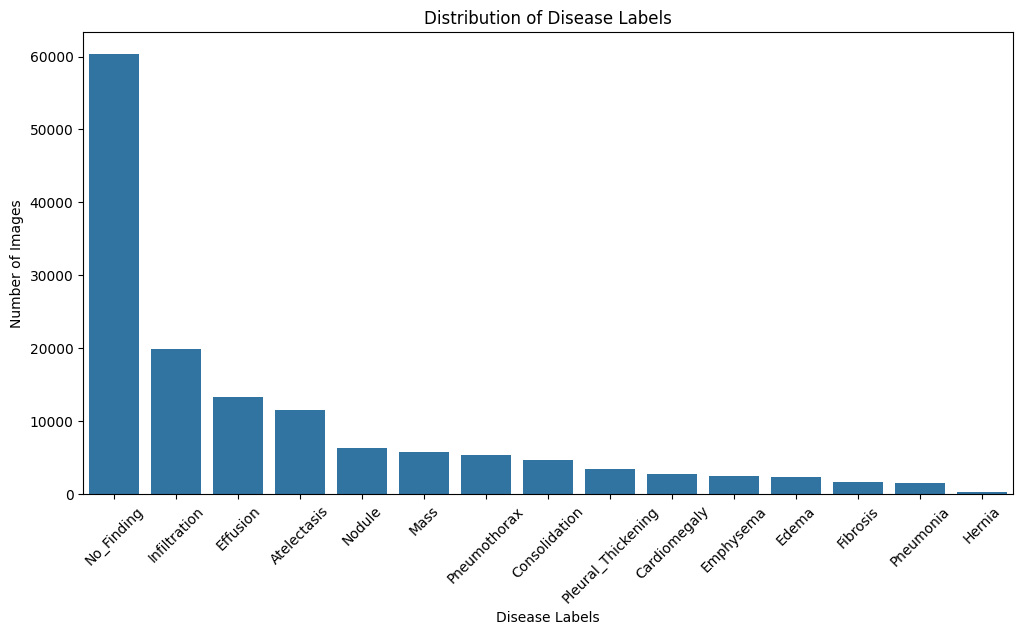

In [ ]:
label_counts = labels_df[disease_labels + ['No_Finding']].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=45)
plt.title("Distribution of Disease Labels")
plt.ylabel("Number of Images")
plt.xlabel("Disease Labels")
plt.show()

**Patient Gender Distribution**

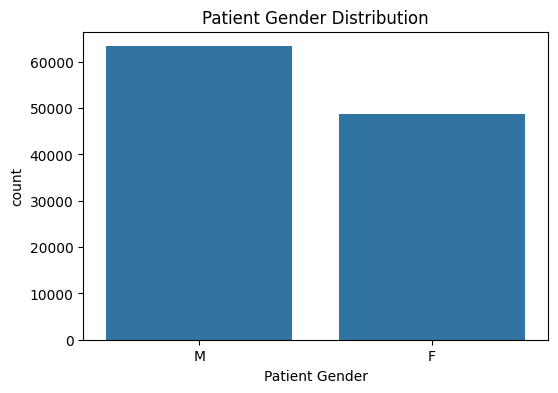

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Patient Gender', data=labels_df)
plt.title("Patient Gender Distribution")
plt.show()

**Patient Age Distribution**

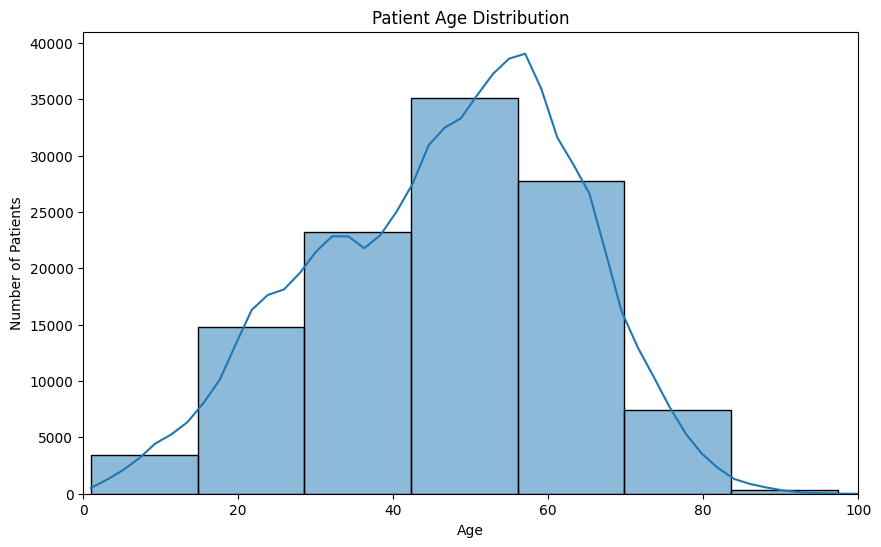

In [ ]:
# Patient Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(labels_df['Patient Age'], bins=30, kde=True)
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.xlim(0, 100)
plt.show()

**View Position Distribution**

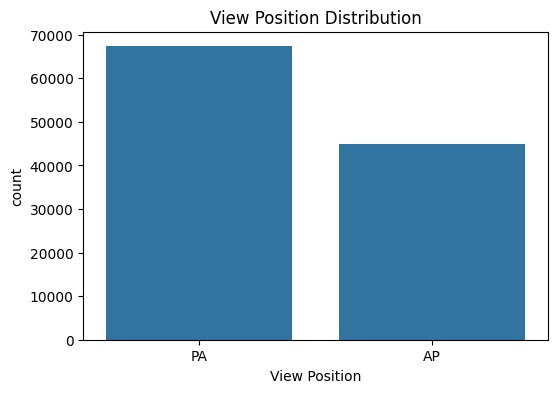

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='View Position', data=labels_df)
plt.title("View Position Distribution")
plt.show()

**Correlation Matrix for Labels**

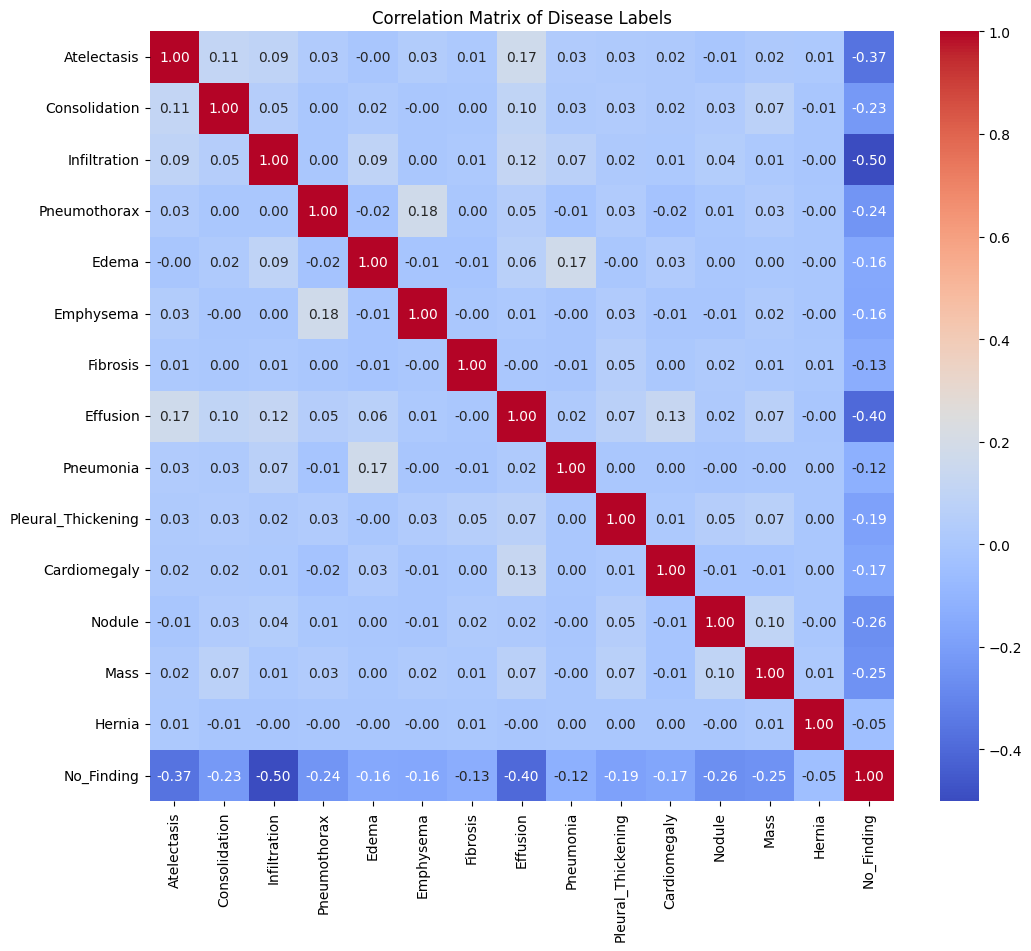

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(labels_df[disease_labels + ['No_Finding']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Disease Labels")
plt.show()

# **Step 5: Split Dataset**

In [ ]:
# Import FastAI Libraries
import fastai
from fastai.vision.all import *

In [ ]:
# Split data
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=SEED)

train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


# **Step 6: Data Processing Part 2**

**Prepare DataLoader for Training**

In [ ]:
# PyTorch Dataset class
class ChestXrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

# Data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Datasets and DataLoaders
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# **Step 7: Build the Model**

In [ ]:
# Define the model
class MultiLabelClassifier(nn.Module):
    def __init__(self):
        super(MultiLabelClassifier, self).__init__()
        self.base_model = models.swin_v2_t(weights=models.Swin_V2_T_Weights.IMAGENET1K_V1)
        self.base_model.head = nn.Linear(self.base_model.head.in_features, len(disease_labels))

    def forward(self, x):
        return self.base_model(x)

model = MultiLabelClassifier()

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# **Step 8: Train the Model**

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)

Epoch 1/10: 100%|██████████| 562/562 [12:38<00:00,  1.35s/it]

Epoch 1, Training Loss: 0.1715


KeyboardInterrupt: 

# **Step 9: Evaluate the Model**

**Prepare DataLoader for Test Set**

In [ ]:
# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels)

    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

preds, labels = evaluate_model(model, test_loader)

# Compute metrics
accuracy_per_label = {}
roc_auc_per_label = {}

for i, label in enumerate(disease_labels):
    acc = accuracy_score(labels[:, i], preds[:, i] > 0.5)
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])
    accuracy_per_label[label] = acc
    roc_auc_per_label[label] = roc_auc

metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'ROC AUC': roc_auc_per_label
})

print(metrics_df)


Evaluating: 100%|██████████| 175/175 [05:44<00:00,  1.97s/it]


                    Accuracy   ROC AUC
Atelectasis         0.901050  0.771791
Consolidation       0.957343  0.790580
Infiltration        0.815915  0.691885
Pneumothorax        0.954562  0.824174
Edema               0.979636  0.872293
Emphysema           0.976092  0.867150
Fibrosis            0.983673  0.750986
Effusion            0.890957  0.856138
Pneumonia           0.986813  0.704302
Pleural_Thickening  0.970396  0.751948
Cardiomegaly        0.972280  0.785158
Nodule              0.942496  0.689817
Mass                0.951870  0.743315
Hernia              0.997847  0.792053


**Calculate Accuracy and ROC AUC**

**Plot ROC curves for each label**

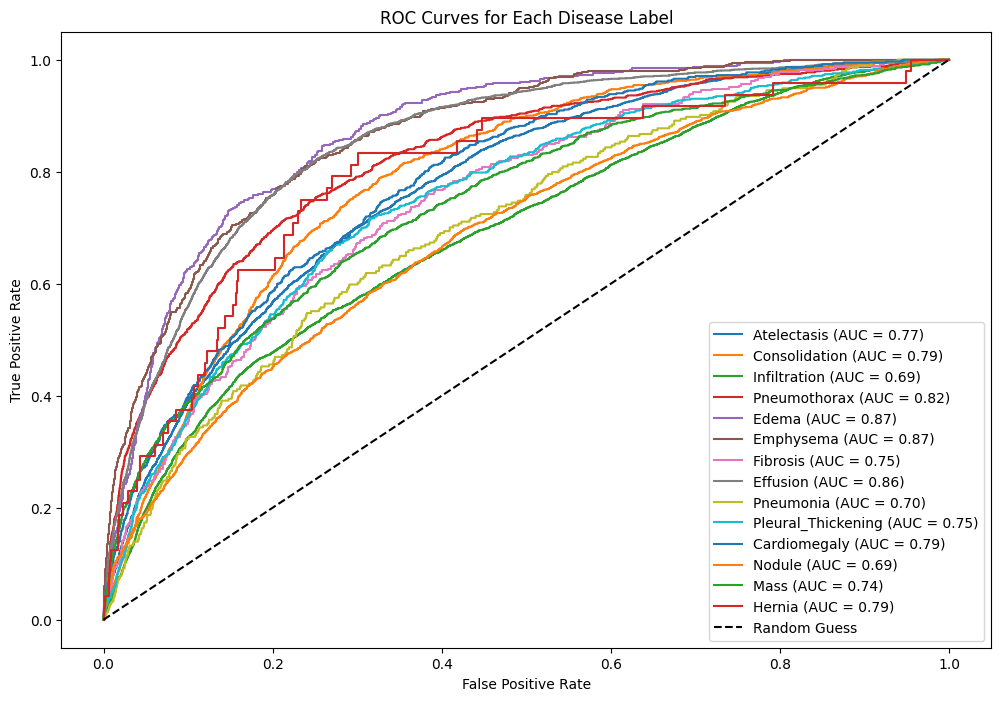

In [ ]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()
